<a href="https://colab.research.google.com/github/Rom1deTroyes/Colab/blob/main/Romain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modèle intelligente pour la détection des masques
![](https://simplonline.co/_next/image?url=https%3A%2F%2Fsimplonline-v3-prod.s3.eu-west-3.amazonaws.com%2Fmedia%2Fimage%2Fjpg%2Fe1b41b71-3725-4169-8494-d7b539be3217.jpg&w=1280&q=75)

Transfer learning pour la détection des masques

NB. Utiliser le Colab pour l'apprentissage du modèle (https://colab.research.google.com/?hl=fr)


## Partie 1 : Base de données, Analyse et Préparation

Le Dataset a été décompressé dans le dossier `Mask_Data`.

Par la suite, il faut développer les étapes suivantes :
- [X] Charger les images.
- [X] Penser à redimensionner les images selon le modèle VGG16.
- [X] Splitter les données en données d’apprentissage, validation et test.
- [X] Visualiser les images de la classe `Avec_Masque` et `Sans_Masque`.


In [ ]:
import os
import cv2
from tqdm import tqdm

# Resize Image to original VGG16 input size
# from the paper: "During training, the input to our ConvNets 
# is a fixed-size 224 × 224 RGB image"
width = 224
height = 224
dim = (width, height)


def load_images(imagePath):
	# read the image from disk, decode it, convert the data type to
	# floating point, and resize it
	image = tf.io.read_file(imagePath)
	image = tf.image.decode_jpeg(image, channels=3)
	image = tf.image.convert_image_dtype(image, dtype=tf.float32)
	image = tf.image.resize(image, dim)
	# parse the class label from the file path
	label = tf.strings.split(imagePath, os.path.sep)[-2]
	
	# return the image and the label
	return (image, label)


def import_data(rootFolderPath):
    data = []
    data_label = []
    total = 0

    for root, dirs, files in os.walk(rootFolderPath):
        print(root, dirs, len(files))
        label = os.path.basename(root)
        total += len(files)
        for file in files:
            path = root+os.sep+file
            img = cv2.imread(path)
            img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
            #img, label = load_images(path)
            data.append(img)
            data_label.append(label)
            
    return(data, data_label)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if drive is not None :
  root_path = '/content/drive/MyDrive/ISEN/Projets/Mask_Detection'
else:
  root_path = "."

In [ ]:
data, data_label = import_data(root_path+os.sep+"Mask_Data")

print(len(data))
print(len(data_label))

/content/drive/MyDrive/ISEN/Projets/Mask_Detection/Mask_Data ['without_mask', 'with_mask'] 0
/content/drive/MyDrive/ISEN/Projets/Mask_Detection/Mask_Data/without_mask [] 753
/content/drive/MyDrive/ISEN/Projets/Mask_Detection/Mask_Data/with_mask [] 755
1508
1508


Les classes sont équilibrées (~750 images dans chaque label), on a donc pas besoin d'en augmenter.

Les targets sont des labels textuels, il faut donc les encoder de façon a travailler sur des nombres.

In [ ]:
print("Cardinalité : ", len(set(data_label)))

Cardinalité :  2


Notre dataset a 2 classes, on peut donc utiliser un `LabelBinarizer` qui va transformer les classes en 0 ou 1.

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
data_target = lb.fit_transform(data_label)

print(len(data_target))

1508


### Splitter les données en données d’apprentissage, validation et test.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, data_target, test_size=20/100, random_state=42)

print("Train : ", len(X_train), len(y_train))
print("Test : ", len(X_test), len(y_test))

Train :  1206 1206
Test :  302 302


### Visualiser les images de la classe `Avec_Masque` et `Sans_Masque`

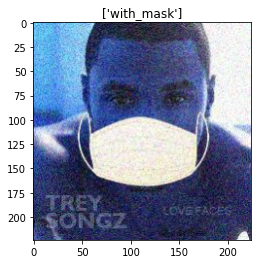

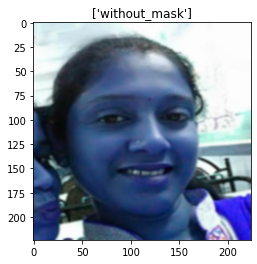

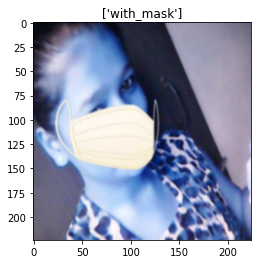

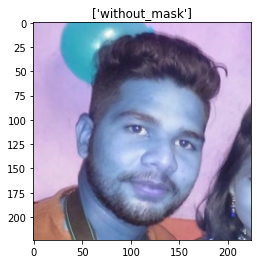

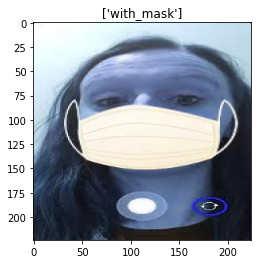

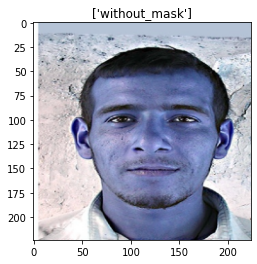

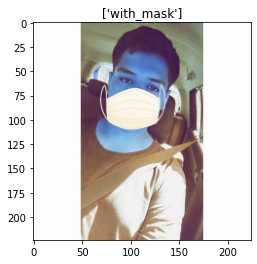

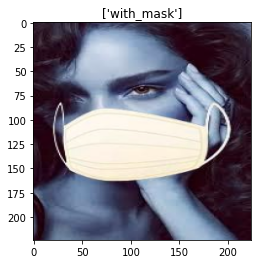

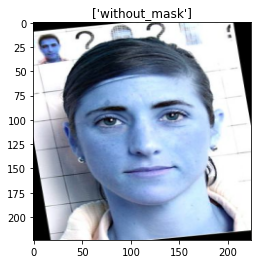

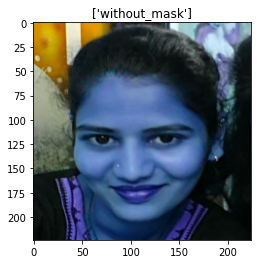

In [ ]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt

# Afficher 10 images pour vérifier la concordance image / label
for num in range(1, len(X_train), round(len(X_train)/10)):
    image = X_train[num]
    #Show the image with matplotlib
    plt.imshow(image)
    plt.title(lb.inverse_transform(y_train[num]))
    plt.show()

## Partie 2 : Architecture CNN sur Tensorflow

Cette deuxième partie est réservée pour développer le modèle CNN sur tensorflow, et lancée par la suite l’apprentissage de CNN.

### Data Augmentation
- Au début, il faut préparer et appliquer la Data Augmentation sur les données d’apprentissage.

In [ ]:
# Data augmentation with tf.data and TensorFlow
from keras import Sequential
from keras import layers as preprocessing
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom


trainAug = Sequential([
	preprocessing.Rescaling(scale=1.0 / 255),
	preprocessing.RandomFlip("horizontal_and_vertical"),
	preprocessing.RandomZoom(
		height_factor=(-0.05, -0.15),
		width_factor=(-0.05, -0.15)),
	preprocessing.RandomRotation(0.3)
])

In [ ]:
from tensorflow.data import Dataset, AUTOTUNE


BATCH_SIZE = 10

trainDS = Dataset.from_tensor_slices((X_train, y_train))
trainDS = (
	trainDS
	.shuffle(BATCH_SIZE * 100)
	.batch(BATCH_SIZE)
	.map(lambda x, y: (trainAug(x), y),
		 num_parallel_calls=AUTOTUNE)
	.prefetch(AUTOTUNE)
)

Modifiaction à la main

In [ ]:
def augment_using_ops(images, labels):
	images = tf.image.random_flip_left_right(images)
	images = tf.image.random_flip_up_down(images)
	images = tf.image.rot90(images)
	return (images, labels)

#ds = Dataset.from_tensor_slices(imagePaths)
#ds = (ds
#	.shuffle(len(imagePaths), seed=42)
#	.map(load_images, num_parallel_calls=AUTOTUNE)
#	.cache()
#	.batch(BATCH_SIZE)
#	.map(augment_using_ops, num_parallel_calls=AUTOTUNE)
#	.prefetch(AUTOTUNE)
#)

### Import des bibliothèques

In [ ]:
import numpy as np
import keras
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.losses import BinaryCrossentropy
import tensorflow as tf

## VGG16 complet

### Charger modèle VGG16

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

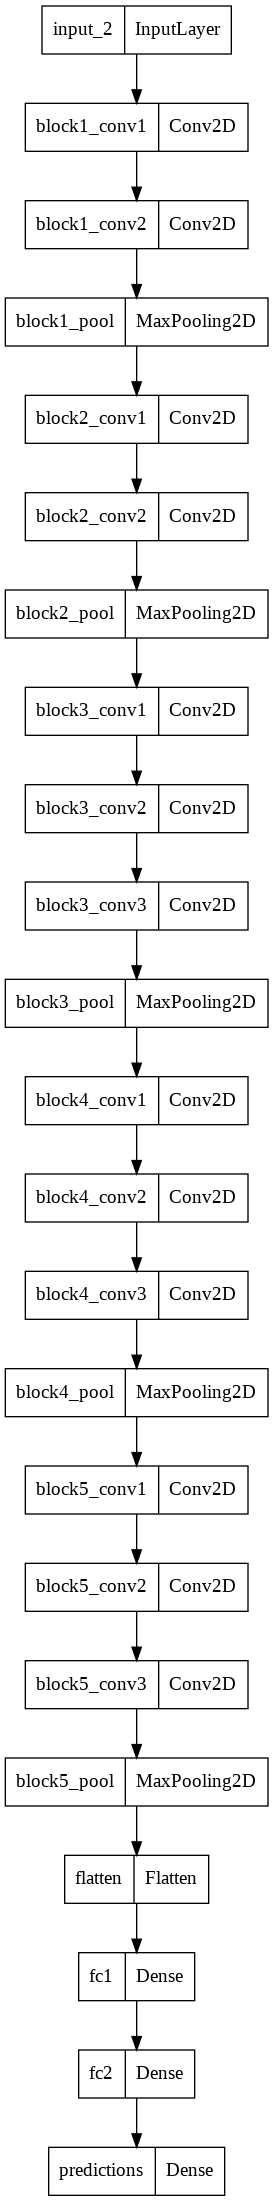

In [ ]:
model_VGG_base = VGG16()
model_VGG_base.summary()

tf.keras.utils.plot_model(model_VGG_base)

### Configurer le modèle VGG16

Ici, nous ne configurons rien, puis que nous utilisons le modèle par défaut.
Note : nous aurons plus de 1000 sorties, et utilisrons que les 2 premières.

### Compilation

In [ ]:
model_VGG_base.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

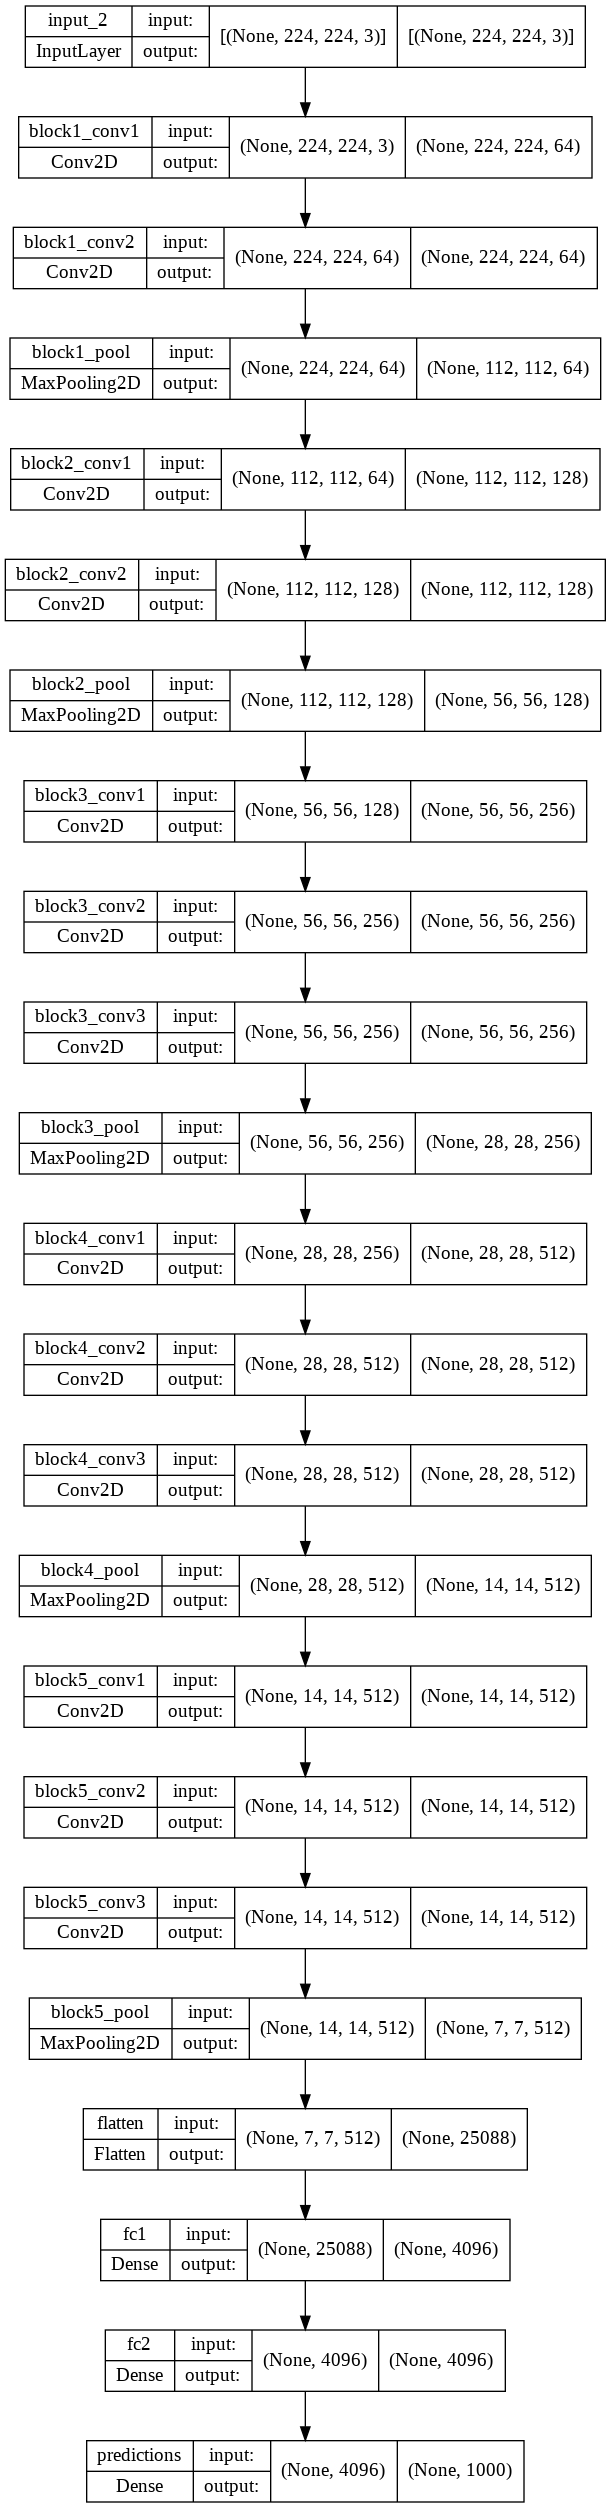

In [ ]:
tf.keras.utils.plot_model(model_VGG_base)

dot_img_file = '/tmp/model_VGG_base.png'
tf.keras.utils.plot_model(model_VGG_base, to_file=dot_img_file, show_shapes=True)


### Checkpoint

Appeler le ModelCheckpoint pour sauvgarder le meilleurs modèle durant l’apprentissage (`from keras.callbacks import ModelCheckpoint`)

In [ ]:
from keras.callbacks import ModelCheckpoint

# construct the callback to save only the *best* model to disk
# based on the validation loss
# monitor="val_loss",
# mode="min",
# verbose=1

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

### Apprentissage

- Lancer un apprentissage en utilisant les données d’apprentissage et les données de validation avec un historique.


In [ ]:
# Normatlisation des images 
from tensorflow import stack

X_train_stacked = stack(X_train)
y_train_stacked = stack(y_train)
X_test_stacked = stack(X_test)
y_test_stacked = stack(y_test)

In [ ]:
history = model_VGG_base.fit(X_train_stacked, y_train_stacked, 
                    validation_data=(X_test_stacked, y_test_stacked),
                    epochs=10,
                    callbacks=[model_checkpoint_callback],
                    )

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


38/38 [==============================] - 2550s 67s/step - loss: 769.6693 - accuracy: 0.4826 - val_loss: 0.9363 - val_accuracy: 0.4901
Epoch 2/10
38/38 [==============================] - 2373s 63s/step - loss: 1.0511 - accuracy: 0.5008 - val_loss: 0.7060 - val_accuracy: 0.5099
Epoch 3/10
 8/38 [=====>........................] - ETA: 29:18 - loss: 0.6875 - accuracy: 0.5352

In [ ]:
tf.keras.utils.plot_model(model_VGG_base)


### évaluaiton

- Tracer les courbes d’accuracy et d’erreur de train et validation.

#### Accuracy

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')
plt.title("Accuracy value by epoch")
plt.show()

#### Loss

In [ ]:
plt.plot(history.history['val_loss'], label = "val_loss")
plt.plot(history.history['loss'], label = "loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.ylim([0, 11])
plt.legend(loc = "upper right")
plt.title("Loss value by epoch")
plt.show()

#### Matrice de confusion

- Calculer l’accuracy et la matrice de confusion sur les données de test.

In [ ]:
test_loss, test_acc = model_VGG_base.evaluate(X_test, y_test, verbose=2)
print(test_acc, test_loss)

In [ ]:
# importing the library
import tensorflow as tf

y_prob = model_VGG_base.predict(X_test_stacked)
y_pred = y_prob.argmax(axis=-1)

# Initializing the input tensor
labels = y_pred
predictions = y_test_stacked
weights = None
 
# Printing the input tensor
#print('labels: ', labels)
#print('Predictions: ', predictions)
#print('Weights: ', weights)
 
# Evaluating confusion matrix
confusion_matrix = tf.math.confusion_matrix(labels, predictions, weights=weights)
confusion_matrix

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(24,12))
sns.heatmap(confusion_matrix, annot=True, linewidths=.5, fmt='.1g', cmap='coolwarm')
plt.title("Matrice de confusion")
plt.show()

### Sauvegarde du modèle

In [ ]:
model_VGG16_base.save(root_path+os.sep+'model_VGG16_base-Romain')

## VGG16 : dernière couche

### Charger modèle VGG16

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

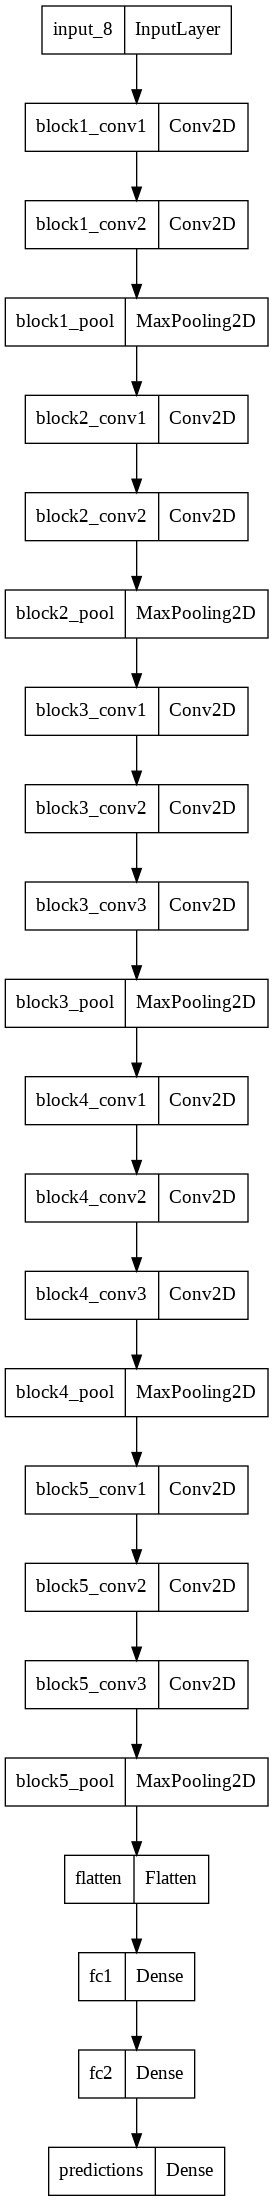

In [ ]:
# Modèle VGG16
model_base = VGG16(weights='imagenet', include_top=False, input_shape = dim+(3,)) 

model_base.summary()
tf.keras.utils.plot_model(model_base)

### Configurer le modèle VGG16

Ici on va redéfinir uniquement la dernière couche du modèle VGG16 : on va donc geler toutes les autres.

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

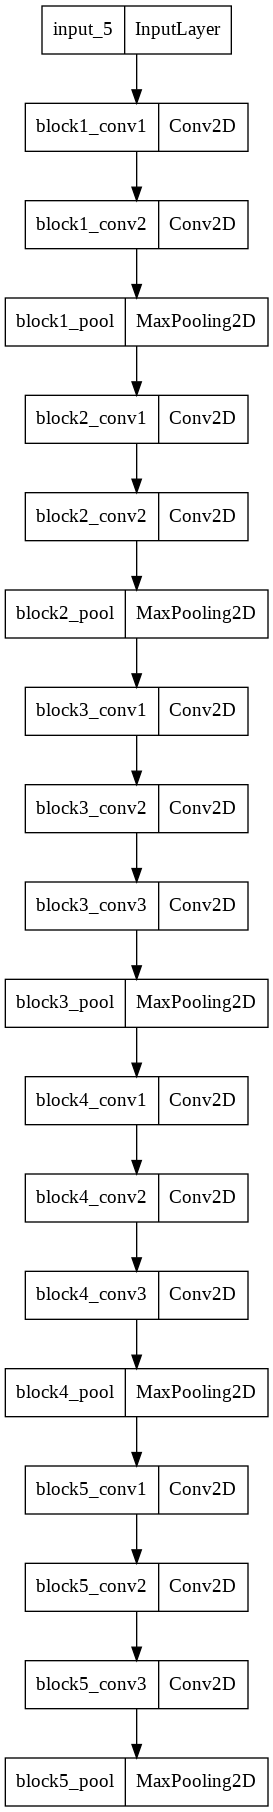

In [ ]:
# Freezer toutes les couches du du modèle VGG16
for layer in model_base.layers: 
    layer.trainable = False

model_base.summary()
tf.keras.utils.plot_model(model_base)


### Défintion de la couche de sortie

La couche de sortie est constituée d'un `softmax` car nous avons 2 catégories possibles en sortie.

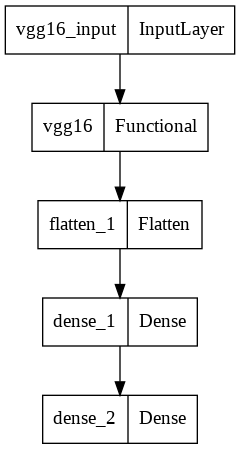

In [ ]:
model = Sequential()
model.add(model_base) # Ajout du modèle VGG16
model.add(Flatten()) 
model.add(Dense(128,activation='relu', name='dense_1'))  # TODO : sigmoid
model.add(Dense(2, activation='softmax', name='dense_2-sortie'))

tf.keras.utils.plot_model(model)

#### Code Amine

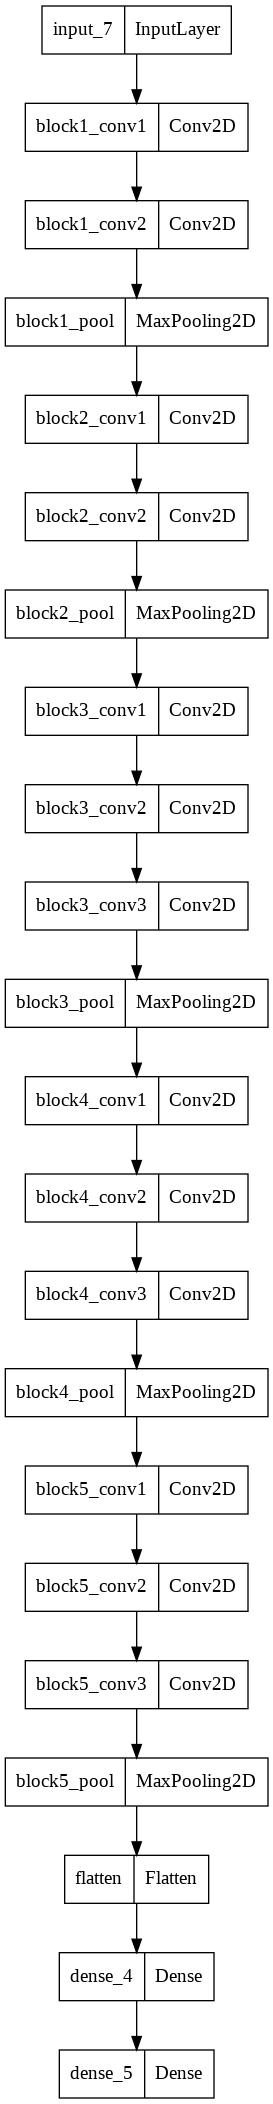

In [ ]:
from keras.layers.advanced_activations import Softmax
# Code Amine
input_shape=dim+(3,)
Nbr_Class = 2
Act = "softmax"
CNN1 = tf.keras.applications.VGG16(include_top=False,input_shape=input_shape)
for layer in CNN1.layers:
    layer.trainable = True
fl = Flatten(name='flatten')(CNN1.output)
model = Dense(128, activation='relu')(fl)
model = Dense(Nbr_Class, activation=Act)(model)
model = Model(inputs=CNN1.input, outputs=model, name='VGG16')

tf.keras.utils.plot_model(model)


### Compilation

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

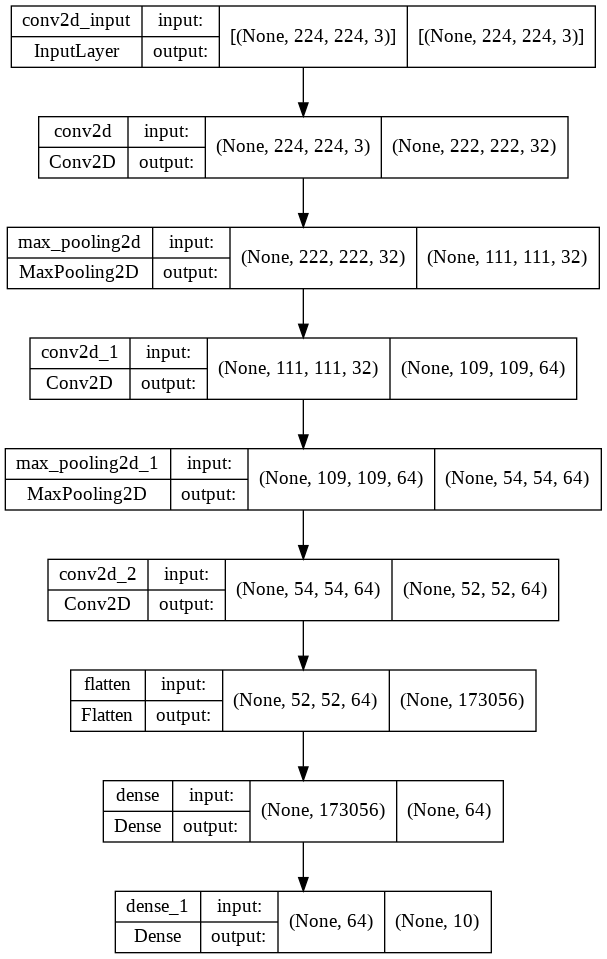

In [ ]:
tf.keras.utils.plot_model(model)

dot_img_file = '/tmp/model_out.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


### Checkpoint

Appeler le ModelCheckpoint pour sauvgarder le meilleurs modèle durant l’apprentissage (`from keras.callbacks import ModelCheckpoint`)

In [ ]:
from keras.callbacks import ModelCheckpoint

# construct the callback to save only the *best* model to disk
# based on the validation loss
# monitor="val_loss",
# mode="min",
# verbose=1

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

### Apprentissage

- Lancer un apprentissage en utilisant les données d’apprentissage et les données de validation avec un historique.


In [ ]:
"""
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print((len(X_train), len(X_train[0])), (len(y_train), len(y_train[0])))
print((len(X_test), len(X_test[0])), (len(y_test), len(y_test[0])))

print(X_train_np.shape, y_train_np.shape)
print(X_test_np.shape, y_test_np.shape)

X_train_scaled = X_train_np/255
X_test_scaled = X_test_np/255

print(X_train_scaled.shape, X_test_scaled.shape)
"""

(1206, 224) (1206, 1)
(302, 224) (302, 1)
(1206, 224, 224, 3) (1206, 1)
(302, 224, 224, 3) (302, 1)
(1206, 224, 224, 3) (302, 224, 224, 3)


In [ ]:
if X_train_stacked is None :

  from tensorflow import stack

  X_train_stacked = stack(X_train)
  y_train_stacked = stack(y_train)
  X_test_stacked = stack(X_test)
  y_test_stacked = stack(y_test)

In [ ]:
history = model.fit(X_train_stacked, y_train_stacked, 
                    validation_data=(X_test_stacked, y_test_stacked),
                    epochs=10,
                    callbacks=[model_checkpoint_callback],
                    )

Epoch 1/10
38/38 [==============================] - 5s 128ms/step - loss: 10.3789 - accuracy: 0.9735 - val_loss: 3.8265 - val_accuracy: 0.9834
Epoch 2/10
38/38 [==============================] - 5s 121ms/step - loss: 1.6724 - accuracy: 0.9818 - val_loss: 0.8076 - val_accuracy: 0.9901
Epoch 3/10
38/38 [==============================] - 4s 111ms/step - loss: 1.6441 - accuracy: 0.9801 - val_loss: 1.3585 - val_accuracy: 0.9801
Epoch 4/10
38/38 [==============================] - 4s 111ms/step - loss: 0.3487 - accuracy: 0.9925 - val_loss: 1.5047 - val_accuracy: 0.9768
Epoch 5/10
38/38 [==============================] - 4s 111ms/step - loss: 0.2227 - accuracy: 0.9942 - val_loss: 2.1631 - val_accuracy: 0.9801
Epoch 6/10
38/38 [==============================] - 4s 111ms/step - loss: 0.2843 - accuracy: 0.9959 - val_loss: 2.1935 - val_accuracy: 0.9735
Epoch 7/10
38/38 [==============================] - 4s 111ms/step - loss: 0.0131 - accuracy: 0.9992 - val_loss: 1.1503 - val_accuracy: 0.9801
Epoch

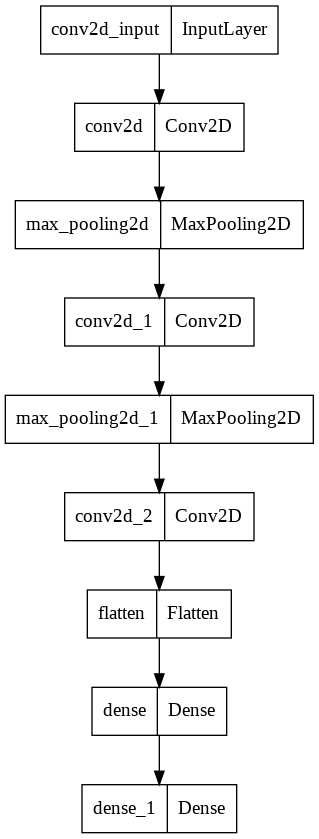

In [ ]:
tf.keras.utils.plot_model(model)


### évaluaiton

- Tracer les courbes d’accuracy et d’erreur de train et validation.

#### Accuracy

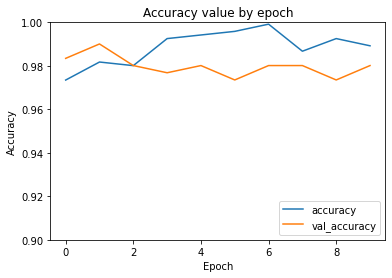

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')
plt.title("Accuracy value by epoch")
plt.show()

#### Loss

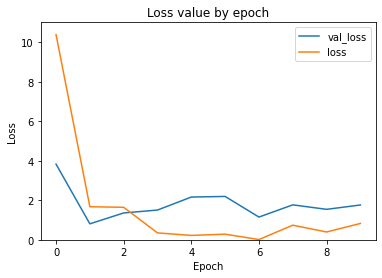

In [ ]:
plt.plot(history.history['val_loss'], label = "val_loss")
plt.plot(history.history['loss'], label = "loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.ylim([0, 11])
plt.legend(loc = "upper right")
plt.title("Loss value by epoch")
plt.show()

#### Matrice de confusion

- Calculer l’accuracy et la matrice de confusion sur les données de test.

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc, test_loss)

10/10 - 1s - loss: 0.5748 - accuracy: 0.9702 - 642ms/epoch - 64ms/step
0.9701986908912659 0.5748462677001953


In [ ]:
# importing the library
import tensorflow as tf

y_prob = model.predict(X_test_stacked)
y_pred = y_prob.argmax(axis=-1)

# Initializing the input tensor
labels = y_pred
predictions = y_test_stacked
weights = None
 
# Printing the input tensor
#print('labels: ', labels)
#print('Predictions: ', predictions)
#print('Weights: ', weights)
 
# Evaluating confusion matrix
confusion_matrix = tf.math.confusion_matrix(labels, predictions, weights=weights)
confusion_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[151,   3],
       [  3, 145]], dtype=int32)>

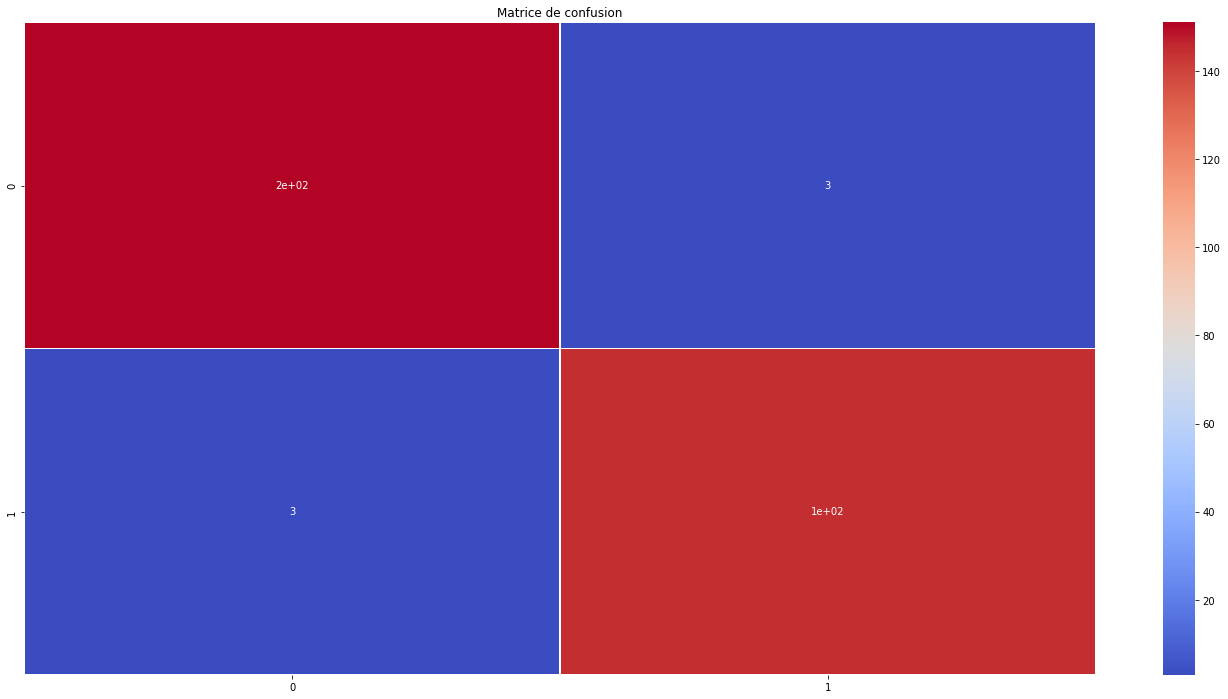

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(24,12))
sns.heatmap(confusion_matrix, annot=True, linewidths=.5, fmt='.1g', cmap='coolwarm')
plt.title("Matrice de confusion")
plt.show()

### Sauvegarde du modèle

In [ ]:
model.save(root_path+os.sep+'model_VGG16_out-Romain')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ISEN/Projets/Mask_Detection/model_VGG16-Romain/assets


## Modèle complet
(pour référence)

### Importer TensorFlow

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import numpy as np

### Préparer le jeu de données

In [ ]:
train_images = np.array(X_train)
train_labels = np.array(y_train)
test_images = np.array(X_test)
test_labels = np.array(y_test)

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


#### Vérifier les données

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


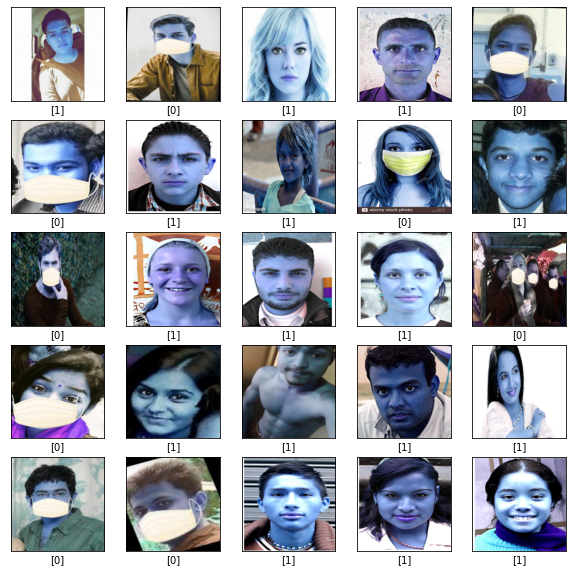

In [ ]:
class_names = np.unique(np.concatenate([train_labels,test_labels]))

plt.figure(figsize=(10,10))

nb_images = 25
img_split = round(len(train_images) / nb_images)

for i in range(nb_images):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i*img_split])
    plt.xlabel(class_names[train_labels[i*img_split].astype(int)])
plt.show()

### Créer la base convolutive

In [ ]:
# Récupération du format de l'image dans la première image du dataset
input_shape = train_images[0].shape
input_shape

(224, 224, 3)

In [ ]:
model_c = models.Sequential()
model_c.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_c.add(layers.MaxPooling2D((2, 2)))
model_c.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_c.add(layers.MaxPooling2D((2, 2)))
model_c.add(layers.Conv2D(64, (3, 3), activation='relu'))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-trai

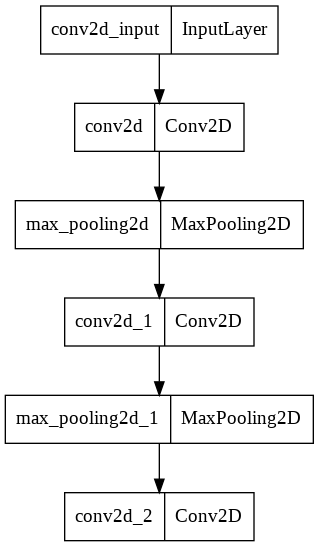

In [ ]:
model_c.summary()
tf.keras.utils.plot_model(model_c)

#### Ajouter des couches denses sur le dessus

In [ ]:
model_c.add(layers.Flatten())
model_c.add(layers.Dense(64, activation='relu'))
model_c.add(layers.Dense(2, name="dense_sortie"))  # 2 classes de sortie


TypeError: ignored

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 173056)           

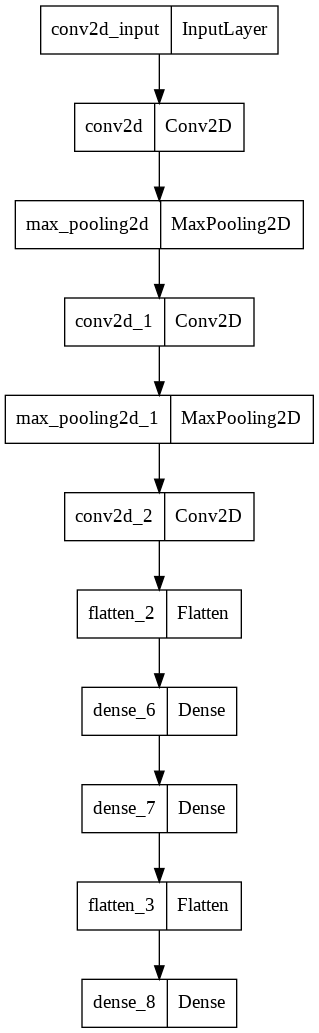

In [ ]:
model_c.summary()

tf.keras.utils.plot_model(model_c)

### Compiler et entraîner le modèle

In [ ]:
model_c.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model_c.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))


Epoch 1/10
38/38 [==============================] - 14s 146ms/step - loss: 3.6572 - accuracy: 0.0000e+00 - val_loss: 2.9349 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 4s 110ms/step - loss: 2.3224 - accuracy: 0.2861 - val_loss: 1.5840 - val_accuracy: 0.5033
Epoch 3/10
38/38 [==============================] - 4s 117ms/step - loss: 1.0613 - accuracy: 0.5705 - val_loss: 0.3547 - val_accuracy: 0.8907
Epoch 4/10
38/38 [==============================] - 4s 110ms/step - loss: 0.1956 - accuracy: 0.9453 - val_loss: 0.0941 - val_accuracy: 0.9636
Epoch 5/10
38/38 [==============================] - 4s 110ms/step - loss: 0.1000 - accuracy: 0.9660 - val_loss: 0.0853 - val_accuracy: 0.9801
Epoch 6/10
38/38 [==============================] - 4s 110ms/step - loss: 0.0741 - accuracy: 0.9801 - val_loss: 0.0807 - val_accuracy: 0.9801
Epoch 7/10
38/38 [==============================] - 4s 110ms/step - loss: 0.0663 - accuracy: 0.9826 - val_loss: 0.0785 - val_accuracy: 0.97

### Évaluer le modèle


#### Accuracy

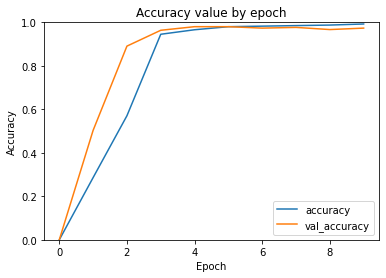

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')
plt.title("Accuracy value by epoch")
plt.show()

#### Loss

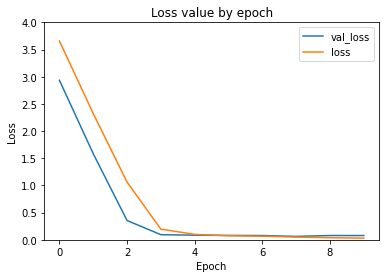

In [ ]:
plt.plot(history.history['val_loss'], label = "val_loss")
plt.plot(history.history['loss'], label = "loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.ylim([0, 4.0])
plt.legend(loc = "upper right")
plt.title("Loss value by epoch")
plt.show()

In [ ]:
test_loss, test_acc = model_c.evaluate(test_images,  test_labels, verbose=2)
print(test_acc, test_loss)

10/10 - 0s - loss: 0.0781 - accuracy: 0.9735 - 459ms/epoch - 46ms/step
0.9735099077224731 0.0781271830201149


#### Matrice de confusion

In [ ]:
# importing the library
import tensorflow as tf

y_prob = model_c.predict(test_images)
y_pred = y_prob.argmax(axis=-1)

# Initializing the input tensor
labels = y_pred
predictions = y_test
weights = None
 
# Printing the input tensor
#print('labels: ', labels)
#print('Predictions: ', predictions)
#print('Weights: ', weights)
 
# Evaluating confusion matrix
confusion_matrix = tf.math.confusion_matrix(labels, predictions, weights=weights)
confusion_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[150,   4],
       [  4, 144]], dtype=int32)>

La matrice de confusion montre que la précision du modèle est bon : il y a une très grande corréaltion entre les données de tests et les résultats prédits.

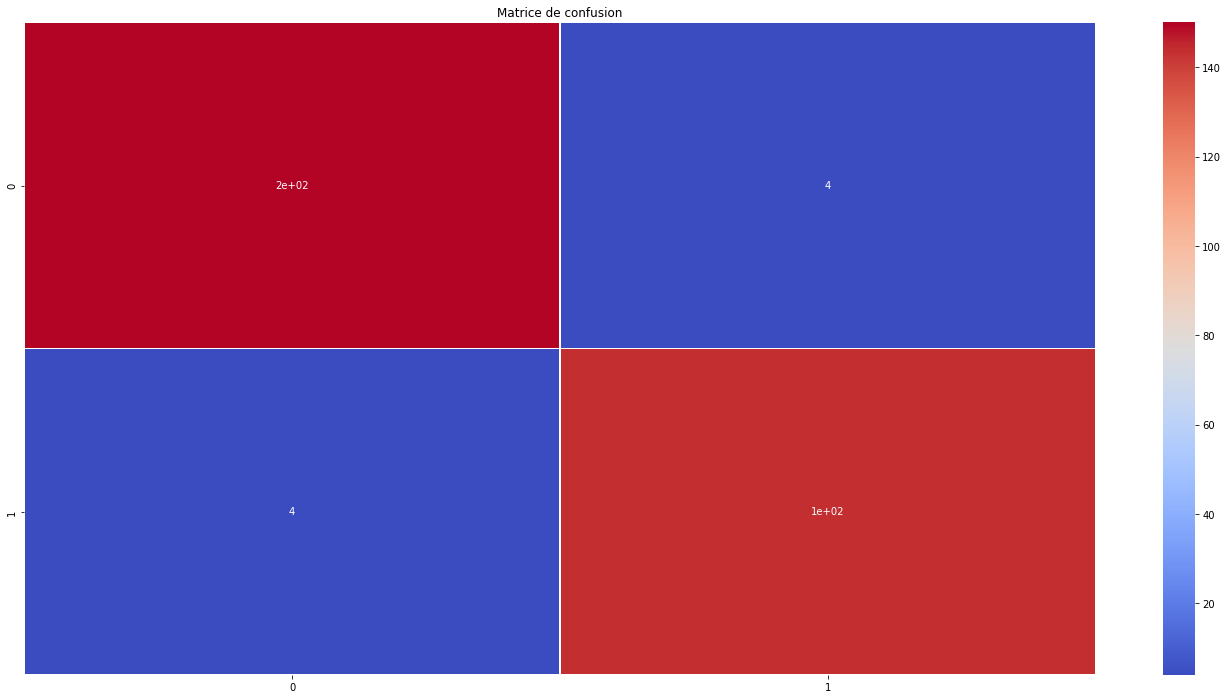

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(24,12))
sns.heatmap(confusion_matrix, annot=True, linewidths=.5, fmt='.1g', cmap='coolwarm')
plt.title("Matrice de confusion")
plt.show()

### Sauvegarde du modèle

In [ ]:
model.save(model.save(root_path+os.sep+'model_CNN-Romain')

INFO:tensorflow:Assets written to: ./model_CNN-Romain/assets


## Partie 3 : Application

Nous cherchons à tester le modèle développé sur des nouvelles images.

Pour un début, cherchez des images sur le net ou prenez photos entre vous et tester le résultat de votre modèle en affichant le message : Avec masque ou Non masque sur l’image. (`cv2.putText(Img, message, (x, y), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))`)


Par la suite, vous êtes censés à développer un code python qui va activer la Webcam et identifier si la personne qui est devant la Webcam porte un masque en affichant le message : Avec masque ou Non masque sur l’image.

### Préparation

#### Import des bibliothèques

In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf

%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt

#### Import du modèle

In [ ]:
model = tf.keras.models.load_model(root_path+os.sep+'model_VGG16-Romain')

In [ ]:
model = tf.keras.models.load_model(root_path+os.sep+'model_CNN-Romain')

#### Import de l'image à tester

In [ ]:
width = 224
height = 224
dim = (width, height)

def preprocess_image(input_image):
    input_image = cv2.resize(input_image, dim, interpolation = cv2.INTER_AREA)
    plt.imshow(input_image)
    plt.show()
    input_image = np.expand_dims(np.array(input_image), axis=0)
    return input_image

def annotate(image, text):
    # Window name in which image is displayed
    window_name = 'Image'
    # font
    font = cv2.FONT_HERSHEY_SIMPLEX
    # org
    org = (round(image.shape[0]/2), round(image.shape[1]/2))
    # fontScale
    fontScale = 5
    # Red color in BGR
    color = (0, 0, 255)
    # Line thickness of 2 px
    thickness = 2
    
    x,y = org
    w,h = 175,75
    # Draw black background rectangle
    image = cv2.rectangle(image, (x, x), (x + w, y + h), (0,0,0), -1)
    # Add text using cv2.putText() method
    image = cv2.putText(image, text, org, font, fontScale, 
                 color, thickness, cv2.LINE_AA, False)

    # Display
    cv2.imshow('image', image)
    cv2.waitKey()

    return image

#### Prédiction

In [ ]:
def predict(image):
    img = cv2.imread(root_path+os.sep+"Input_Data"+os.sep+image)
    image = preprocess_image(img)
    prob = model.predict(image)
    prediction = prob[0].argmax(axis = -1)
    
    
    #predictions = (model.predict(x_test) > 0.5).astype("int32")
    #print(model.eval(feed_dict={x: ["With", "Without"]}))
    
    prediction_label = lb.inverse_transform(np.array(prediction))
    
    img = annotate(img, f"{prediction_label[0]}")

    plt.imshow(img)
    plt.show()
    print(f"Prediction : {prediction_label} ({prediction})")
    for n, p in enumerate(prob[0]):
        print(n, p)
    return(prediction_label)

#### Avec Masque

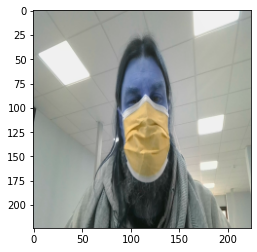

DisabledFunctionError: ignored

In [ ]:
# Avec Masque
predict("Romain-With.jpg")

#### Sans masque

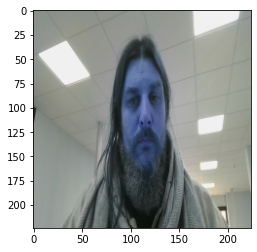

DisabledFunctionError: ignored

In [ ]:
# Sans masque
predict("Romain-Without.jpg")

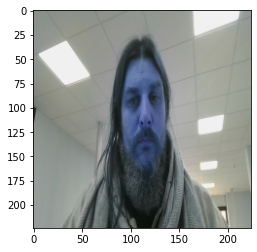

DisabledFunctionError: ignored

In [ ]:
# 
for image in os.listdir(root_path+os.sep+'Input_Data'):
    predict(image)

## Capture vidéo

In [ ]:
#from keras.models import load_model
import cv2

labels_dict={0:'Avec masque',1:'Sans Masque'}
color_dict={0:(0,255,0),1:(0,0,255)}

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

frame_width = int(webcam.get(3)) 
frame_height = int(webcam.get(4)) 
   
size1 = (frame_width, frame_height) 
   
# Below VideoWriter object will create 
# a frame of above defined The output  
# is stored in 'filename.avi' file. 
result1 = cv2.VideoWriter('capture.avi',  
                         cv2.VideoWriter_fourcc(*'MJPG'), 
                         10, size1) 


# We load the xml file
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


def preprocess(image):
    pass
    

for t in range(240):
    
    (rval, im) = webcam.read()    
    
    im=cv2.flip(im,1,1) #Flip to act as a mirror

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    cv2.imshow('Mini', mini)
    #annotate(mini, f"t:{t}")
    # detect MultiScale / faces
    faces = mini
    try:
        faces = classifier.detectMultiScale(mini)
    except:
        print("Unexpected error: detect")
    
    print(faces)
    # Draw rectangles around each face
    for f in faces:
        
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(224,224))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,224,224,3))
        reshaped = np.vstack([reshaped])
        result=improved_model.predict(reshaped)
        
        label=np.argmax(result,axis=1)[0]
        
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    result1.write(im)   
    # Show the image
    cv2.imshow('LIVE', im)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break
# Stop video
webcam.release()
result1.release()

# Close all started windows
cv2.destroyAllWindows()

Unexpected error: detect
[[[ 51 113 101]
  [ 58 113  98]
  [ 59 111  95]
  ...
  [ 66 117 104]
  [ 61 117  99]
  [ 60 118 101]]

 [[ 53 114  98]
  [ 58 112  95]
  [ 60 113  97]
  ...
  [ 63 118 106]
  [ 62 118 104]
  [ 59 117 102]]

 [[ 57 114  99]
  [ 59 115  99]
  [ 63 114  98]
  ...
  [ 62 116 104]
  [ 62 118 103]
  [ 60 117 101]]

 ...

 [[ 11  84  62]
  [  1  70  49]
  [ 55 111  92]
  ...
  [  0  35   0]
  [  0  40   2]
  [  0  43   5]]

 [[  8  78  61]
  [  2  72  53]
  [ 44 104  87]
  ...
  [  0  30   0]
  [  0  38   0]
  [  0  40   1]]

 [[ 12  82  59]
  [  0  69  51]
  [ 35  91  75]
  ...
  [  0  17   1]
  [  0  21   1]
  [  0  23   0]]]


ValueError: too many values to unpack (expected 4)

In [ ]:
webcam.release()
result1.release()

NameError: name 'webcam' is not defined

## Face Detection

In [ ]:
import cv2
import os
#import numpy as np
#import tensorflow as tf

#%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
#from matplotlib import pyplot as plt

face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml") #Note the change

for img in os.listdir('Input_Data'):
    img = cv2.imread('Input_Data'+os.sep+img)
    gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(gray_img, scaleFactor=1.05,minNeighbors=5)
    for x, y, w, h in faces:
        img=cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)
    resized=cv2.resize(img,(int(img.shape[1]/3), int(img.shape[0]/3))) 
    cv2.imshow("Deteced-face",resized)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
import numpy as np
import cv2
import time

# multiple cascades: https://github.com/Itseez/opencv/tree/master/data/haarcascades

#https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
#https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_eye.xml
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

cap = cv2.VideoCapture(0)
print(cap)

for t in range(123):
    if cap.isOpened() :
        time.sleep(1)
        ret, img = cap.read()
        time.sleep(2)
        ret, img = cap.read()
        print(ret, len(img))
    
    if ret is False : continue

    cv2.imshow('img',img)

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    print(len(gray_img))
    cv2.imshow('Gray',gray_img)

    faces = []
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.05,minNeighbors=5)
    print(faces)
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex,ey,ew,eh) in eyes:
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

    cv2.imshow('img',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()
print("The end !")

<VideoCapture 00000195919D98D0>
True 480
480


error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'


In [ ]:
cap.release()
cv2.destroyAllWindows()